In [10]:
import esm
import pandas as pd
import torch

In [11]:
model, alphabet = esm.pretrained.esm1_t12_85M_UR50S()

if torch.cuda.is_available():
    model = model.cuda()
    print("Modell auf GPU geladen.")
model.eval()  # Set the model to evaluation mode
print(model)

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1_t12_85M_UR50S.pt" to /dss/dsshome1/04/ra58seq2/.cache/torch/hub/checkpoints/esm1_t12_85M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1_t12_85M_UR50S-contact-regression.pt" to /dss/dsshome1/04/ra58seq2/.cache/torch/hub/checkpoints/esm1_t12_85M_UR50S-contact-regression.pt
ProteinBertModel(
  (embed_tokens): Embedding(35, 768, padding_idx=1)
  (layers): ModuleList(
    (0-11): 12 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=768, out_features=768, bias=True)
        (v_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_proj): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (self_attn_layer_norm): ESM1LayerNorm()
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (fc2): Linear(in_features=3072, out_features=768,

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# The 20 standard amino acids
standard_aas = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 
                'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Biochemical properties as defined in Figure 1 of the paper
aa_properties = {
    'Hydrophobic': ['M', 'L', 'I', 'V'],
    'Aromatic': ['F', 'W', 'Y'],
    'Polar': ['N', 'Q', 'S', 'T'],
    'Positively Charged': ['R', 'K', 'H'],
    'Negatively Charged': ['D', 'E'],
    'Unique/Small': ['G', 'P', 'C', 'A']
}

# Visualization styles (colors and markers)
group_styles = {
    'Hydrophobic': {'color': 'green', 'marker': 'o'},
    'Aromatic': {'color': 'forestgreen', 'marker': '+'},
    'Polar': {'color': 'blue', 'marker': '.'},
    'Positively Charged': {'color': 'red', 'marker': 's'},
    'Negatively Charged': {'color': 'red', 'marker': 'x'},
    'Unique/Small': {'color': 'orange', 'marker': '*'}
}

In [13]:
# 1. Determine the device from the model parameters
device = next(model.parameters()).device
print(f"Model is on device: {device}")

# 2. Get indices for standard amino acids
indices = [alphabet.get_idx(aa) for aa in standard_aas]
indices_tensor = torch.tensor(indices, device=device)

# 3. Extract the static embedding weights
# We use embed_tokens directly as this represents the learned "identity" of each AA
with torch.no_grad():
    embeddings = model.embed_tokens.weight[indices_tensor].cpu().numpy()

print(f"Extracted embeddings shape: {embeddings.shape}") 
# Expected Output: (20, 768)

Model is on device: cpu
Extracted embeddings shape: (20, 768)


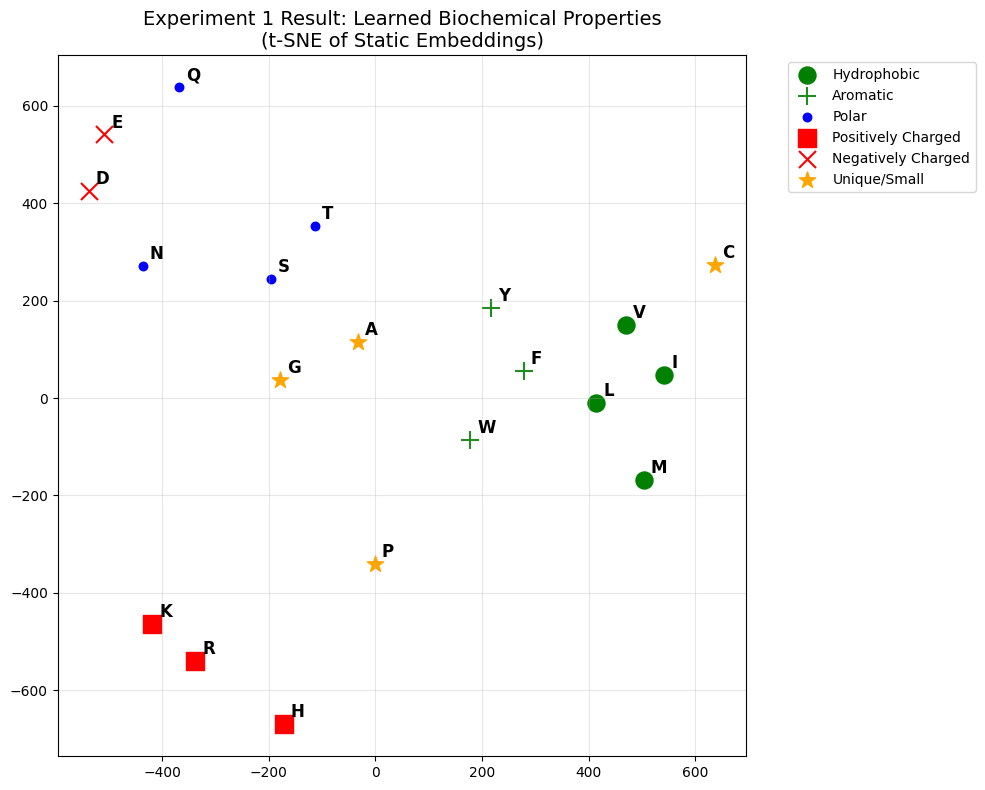

In [14]:
# 1. Compute t-SNE
# Perplexity is low (5) because we only have 20 data points
tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='pca', learning_rate=200)
embeddings_2d = tsne.fit_transform(embeddings)

# 2. Generate Plot
plt.figure(figsize=(10, 8))

# Plot each group
for label, aas in aa_properties.items():
    style = group_styles[label]
    
    # Get indices for AAs in this group relative to our list of 20
    group_indices = [standard_aas.index(aa) for aa in aas]
    
    # Extract X and Y coordinates
    x = embeddings_2d[group_indices, 0]
    y = embeddings_2d[group_indices, 1]
    
    # Scatter plot
    plt.scatter(x, y, c=style['color'], marker=style['marker'], s=150, label=label)
    
    # Annotate points with the amino acid letter
    for i, idx in enumerate(group_indices):
        plt.annotate(standard_aas[idx], (x[i], y[i]), 
                     xytext=(5, 5), textcoords='offset points', 
                     fontsize=12, weight='bold')

plt.title("Experiment 1 Result: Learned Biochemical Properties\n(t-SNE of Static Embeddings)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()